In [1]:
%cd ~/github/agn_lf/
import source.astro_functions as af
import source.table_functions as tf
import source.lf_xi2 as xi2
import source.vmax as vmax
import source.utils as utils
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import astropy.table as table
import astropy.units as u
import source.selection_criteria as sc


from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

/Users/runburg/github/agn_lf


In [2]:
catalog = table.Table.read('./data/master_cat_irac3_mips24')


flux36 = 'f_ap_irac_i1'
flux45 = 'f_ap_irac_i2'
flux58 = 'f_ap_irac_i3'
flux80 = 'f_ap_irac_i4'
flux240 = 'f_mips_24'
# print(catalog[flux58][catalog[flux58] < 0])
never_nan = (np.nan_to_num(catalog[flux58], nan=-99) > 0) & (np.nan_to_num(catalog[flux80], nan=-99) > 0) #& (np.nan_to_num(catalog['zspec'], nan=-99) > 0)
selected_agn = sc.select_ir(catalog[never_nan], flux36, flux45, flux58, flux80, selection_cuts='lacy05')
ct_lacy = catalog[never_nan][selected_agn]
ct_lacy = ct_lacy[(np.nan_to_num(ct_lacy['z1_median'], nan=-99) > 0 ) | (np.nan_to_num(ct_lacy['zspec'], nan=-99) > 0)]
print(len(ct_lacy))

cosmo = af.setup_cosmology()

5914


In [3]:
z_sample_min = 0.5
z_sample_max = 4
l_sample_min = 3e42
l_sample_max = 3e46

num_bins_z = 10
num_bins_l = 15
# redshift range 
z_bins = np.logspace(np.log10(z_sample_min), np.log10(z_sample_max), num=num_bins_z)
# print(z_bins)
l_bins = np.logspace(np.log10(l_sample_min), np.log10(l_sample_max), num=num_bins_l)

field_coverage_area = 9.1

wavelength = 5.8
unit_conversion = 3 / wavelength * 1e-15
flux_limit = 43 * unit_conversion

spectral_index = np.log10(ct_lacy[flux240].data/ct_lacy[flux58].data) / np.log10(24/5.8)

full_fluxes = catalog[never_nan][flux58]
goodzs = (ct_lacy['z1_median'] > 0) & (ct_lacy['zspec'] > 0)
difs = ct_lacy['z1_median'][goodzs] - ct_lacy['zspec'][goodzs]

bolo_corr = 1
# bolo_corr = 8
# ct_lacy['random_z'] = 0#ct_lacy['z1_median']

N = 1000


/usr/local/lib/python3.8/site-packages/astropy/table/column.py:1020: RuntimeWarning: invalid value encountered in greater
  result = getattr(super(), op)(other)


In [13]:
import time
start_time = time.time()
lf_chain = np.zeros((N, num_bins_z-1, num_bins_l-1))
# lf_err_chain = lf_chain[:]

for i in range(N):
    if i % 10 == 0:
        print('progress', round(i/N * 100, 2), '%')
    
    randomz = np.zeros(len(ct_lacy))
    ### use zphot - zspec to estimate uncertainty on z
    for j in np.arange(len(z_bins) - 1):
        inbin = (ct_lacy['z1_median'][goodzs] >= z_bins[j]) & (ct_lacy['z1_median'][goodzs] < z_bins[j+1])
        histo, bin_edges = np.histogram(difs[inbin], bins=200)

        photoz_inbin = (ct_lacy['z1_median'] >= z_bins[j]) & (ct_lacy['z1_median'] < z_bins[j+1])
        randomz[photoz_inbin] = ct_lacy['z1_median'][photoz_inbin] - np.random.choice((bin_edges[:-1]), size=np.sum(photoz_inbin), p=histo/np.sum(histo))
        
        while np.any(randomz < 0):
            indices = randomz < 0
            randomz[indices] = ct_lacy['z1_median'][indices] - np.random.choice((bin_edges[:-1]), size=np.sum(indices), p=histo/np.sum(histo))
#         ct_lacy['random_z'][photoz_inbin] = ct_lacy['z1_median'][photoz_inbin]
        
    ct_lacy['random_z'] = randomz
    z = np.array([row['zspec'] if row['zspec'] > 0 else row['random_z'] for row in ct_lacy])   
    ###
    
#     z = np.array([row['zspec'] if row['zspec'] > 0 else np.random.normal(row['z1_median'], (row['z1_max'] - row['z1_min'])/2) for row in ct_lacy])   
#     z = np.array([row['zspec'] if row['zspec'] > 0 else row['z1_median'] for row in ct_lacy])
#     z[z < 0] = 0
    
    l = 4 * np.pi * cosmo.luminosity_distance(z).to(u.cm).value**2 * ct_lacy[flux58].data * unit_conversion * (1 + z)**(-1 + spectral_index) * bolo_corr
    
    good_redshift_and_l_selected = (l_sample_min < l) & (l_sample_max > l) & (z_sample_min < z) & (z_sample_max > z)
    l = l[good_redshift_and_l_selected]
    z = z[good_redshift_and_l_selected]
#     print(time.time() - start_time)
    
    coverage_correction = vmax.coverage_correction(ct_lacy[flux58], ct_lacy[flux58][good_redshift_and_l_selected])
    
    zmax = vmax.compute_zmax(l, z, cosmo, flux_limit, zspacing=0.5, jack_version=False, output=False)
    zmin = np.array([0]*len(zmax))
#     print(time.time() - start_time)

    def corrected_cov_func(l, z):
        flux = l / (4 * np.pi * cosmo.luminosity_distance(z).to(u.cm).value**2)
        
        return field_coverage_area * coverage_correction(flux)

    vmax_vals = vmax.compute_binned_vmax_values(l, (z, zmin, zmax), l_bins, z_bins, cosmo, bin_z_bounds=False, coverage=corrected_cov_func)
#     print(time.time() - start_time)
    
    lf_vals, lf_errs = vmax.compute_lf_values(l, z, vmax_vals, z_bins, l_bins)
#     print(time.time() - start_time)
    
    lf_chain[i] = lf_vals
#     lf_err_chain[i] = lf_errs
    
print(total_time := time.time() - start_time, total_time/N)


progress 0.0 %
progress 1.0 %
progress 2.0 %
progress 3.0 %
progress 4.0 %
progress 5.0 %
progress 6.0 %
progress 7.0 %
progress 8.0 %
progress 9.0 %
progress 10.0 %
progress 11.0 %
progress 12.0 %
progress 13.0 %
progress 14.0 %
progress 15.0 %
progress 16.0 %
progress 17.0 %
progress 18.0 %
progress 19.0 %
progress 20.0 %
progress 21.0 %
progress 22.0 %
progress 23.0 %
progress 24.0 %
progress 25.0 %
progress 26.0 %
progress 27.0 %
progress 28.0 %
progress 29.0 %
progress 30.0 %
progress 31.0 %
progress 32.0 %
progress 33.0 %
progress 34.0 %
progress 35.0 %
progress 36.0 %
progress 37.0 %
progress 38.0 %
progress 39.0 %
progress 40.0 %
progress 41.0 %
progress 42.0 %
progress 43.0 %
progress 44.0 %
progress 45.0 %
progress 46.0 %
progress 47.0 %
progress 48.0 %
progress 49.0 %
progress 50.0 %
progress 51.0 %
progress 52.0 %
progress 53.0 %
progress 54.0 %
progress 55.0 %
progress 56.0 %
progress 57.0 %
progress 58.0 %
progress 59.0 %
progress 60.0 %
progress 61.0 %
progress 62.0 %
pr

In [5]:
np.sum(ct_lacy['random_z'][good_redshift_and_l_selected] > 0), np.sum(ct_lacy['z1_median'][good_redshift_and_l_selected] > 0)

KeyError: 'random_z'

(1.412519474120427e-54, 186.6130594776925, 0)

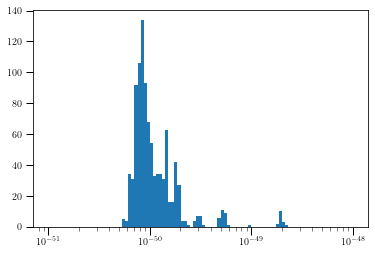

In [14]:
lf_mean = np.mean(lf_chain, axis=0)
lf_mean_err = np.std(lf_chain, axis=0)
# print(lf_mean_err*np.log(10)*(l_bins[1:]-l_bins[:-1])/2)
plt.hist(lf_chain[:, 3, 8], bins=np.logspace(-51, -48, num=100))
ax = plt.gca()
ax.set_xscale('log')
bin_centers = (l_bins[1:]+l_bins[:-1])/2
min(lf_chain[:, 8, -1]), lf_mean[8, -1]*bin_centers[-1]*np.log(10), np.sum(np.isnan(lf_chain))


In [15]:
sorted_lf = np.sort(lf_chain, axis=0)
# probs = np.cumsum(sorted_lf, axis=0)
# probs /= probs[-1]
# probs = np.nan_to_num(probs)
# print(probs)
mid_id = len(sorted_lf) // 2
high_id = (len(sorted_lf) * 84) // 100
low_id = (len(sorted_lf) * 16) // 100
print(low_id, mid_id, high_id, len(sorted_lf))

sh = sorted_lf.shape
median_vals = np.zeros((sh[1], sh[2]))
med_errs = np.zeros((sh[1], 2, sh[2]))
# low_errs = np.zeros((sh[1], sh[2]))
for i in range(sh[1]):
    for j in range(sh[2]):
        median_vals[i, j] = sorted_lf[:, i, j][mid_id]
        med_errs[i, 1, j] = sorted_lf[:, i, j][high_id]
        med_errs[i, 0, j] = sorted_lf[:, i, j][low_id]
        

160 500 840 1000


In [16]:
plot_files = ['./output/lf_xray_montecarlo.npz']
plot_files = []
labs = ['xray mc']
otherruns = {}
for lab, fil in zip(labs, plot_files):
    with np.load(fil) as infile:
        lfv = infile['lf_vals']
        lfe = infile['lf_errs']
    otherruns[lab] = [lfv, lfe]


In [17]:
hz_convert = 5.8e-6 / 3e8
lit_data = {}
lacy_ir_evol_params_central = {'A': 10**-4.75, 
                               'gamma1':1.07, 
                               'gamma2':2.48,
                               'Lstar': 10**31.92 / hz_convert,
                               'zref':2.5,
                               'k1':1.05,
                               'k2':-4.71,
                               'k3':-0.034
                              }
lacy_ir_evol_params_max = {'A': 10**-4.73, 
                               'gamma1':1.13, 
                               'gamma2':2.53,
                               'Lstar': 10**31.94 / hz_convert,
                               'zref':2.5,
                               'k1':1.08,
                               'k2':-4.58,
                               'k3':0.156
                              }
lacy_ir_evol_params_min = {'A': 10**-4.77, 
                               'gamma1':1.01, 
                               'gamma2':2.43,
                               'Lstar': 10**31.9 / hz_convert,
                               'zref':2.5,
                               'k1':1.02,
                               'k2':-4.84,
                               'k3':-0.224
                              }

center_zbins = (z_bins[1:] + z_bins[:-1]) / 2
ls = np.logspace(43, 46.2, num=50)
lacy_mid = af.IR_evol(ls, center_zbins, **lacy_ir_evol_params_central)
lacy_high = af.IR_evol(ls, center_zbins, **lacy_ir_evol_params_max)
lacy_low = af.IR_evol(ls, center_zbins, **lacy_ir_evol_params_min)
# print(lacy_mid[0])
lit_data['Lacy 2015'] = list(zip(lacy_mid, lacy_high, lacy_low))
# lacy_mid[1][:10]

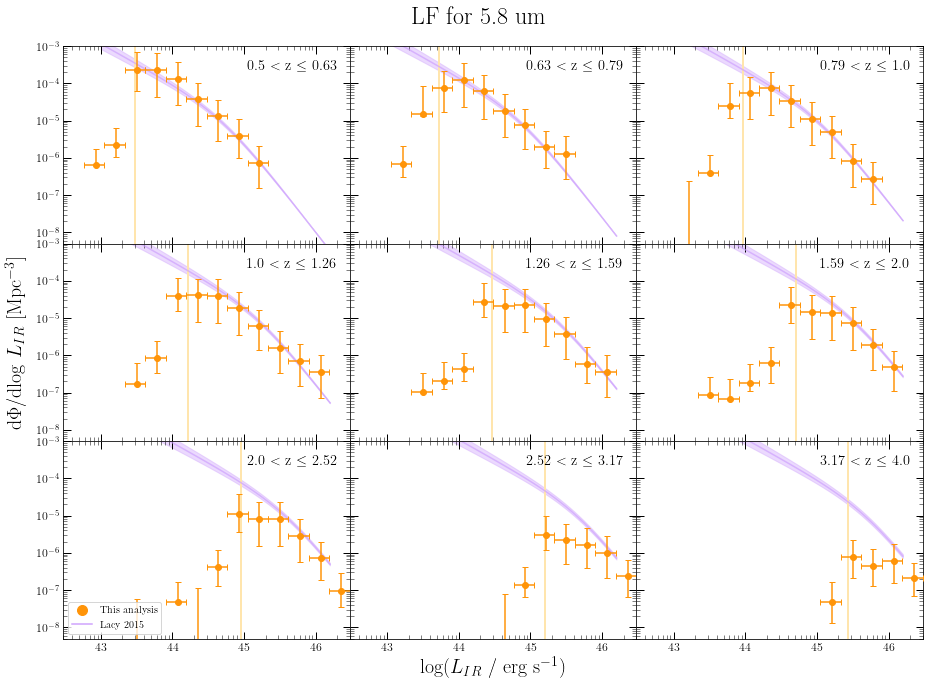

In [19]:
import importlib
importlib.reload(vmax)

np.savez('./output/lf_ir_montecarlo.npz', lf_vals=lf_mean, lf_errs=lf_mean_err)

l_limits = 4 * np.pi * cosmo.luminosity_distance((z_bins[:-1]+z_bins[1:])/2)**2 * flux_limit/(u.cm**2)
l_limits = l_limits.decompose()
fig, axs, big_ax = vmax.plot_lf_vmax(median_vals, med_errs, z_bins, l_bins, lum_limits=l_limits, \
                                     compare_to_others=lit_data, other_runs=otherruns, title='LF for 5.8 um', \
                                     outfile='./output/ir_montecarlo_lf.pdf', lum_sublabel=r'_{IR}')

In [11]:
median_vals

array([[0.00000000e+00, 3.71580737e-50, 5.77377905e-50, 3.54427230e-48,
        1.73996389e-48, 5.21471599e-49, 7.34104071e-50, 1.36307916e-50,
        1.85790368e-51, 1.92459302e-52, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 1.14470371e-50, 1.18579278e-50,
        4.01007903e-49, 4.31041936e-49, 1.16983414e-49, 1.96281557e-50,
        3.97813835e-51, 4.57881485e-52, 1.77868917e-52, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        7.63569204e-50, 1.57680852e-49, 1.32438153e-49, 3.25764816e-50,
        5.62430205e-51, 1.34996993e-51, 1.10402133e-52, 1.90608350e-53,
        0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 2.39708818e-51,
        6.20782875e-51, 1.19177614e-49, 7.94832433e-50, 3.74357554e-50,
        9.29278566e-51, 1.52725739e-51, 2.63679699e-52, 4.96626300e-53,
        1.286